In [1]:
%pylab inline
from poorLowCost_copy import * 
Vgrid = np.load("poorLow.npy")
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})

Populating the interactive namespace from numpy and matplotlib


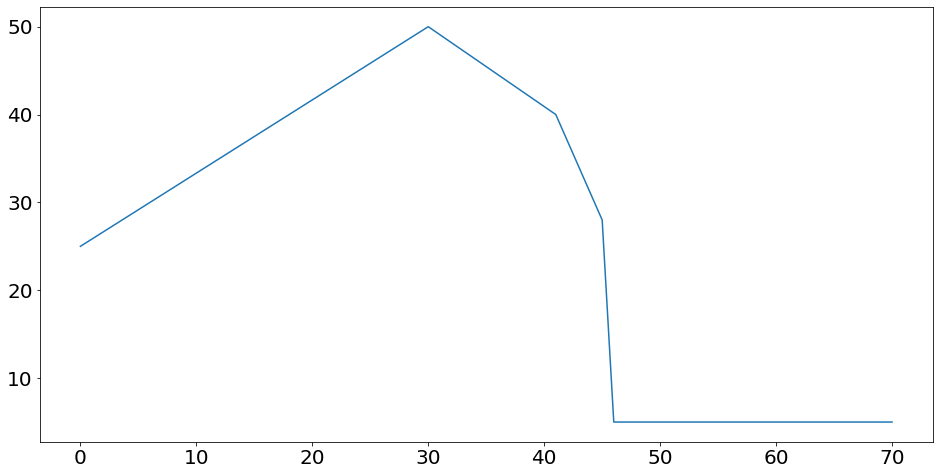

In [47]:
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 20})
plt.plot(detEarning)

In [3]:
num = 10000
'''
    x = [w,n,m,s,e,o,z]
    x = [5,0,0,0,0,0,0]
'''

from jax import random

def simulation(key):
    initE = random.choice(a = nE, p=E_distribution, key = key)
    initS = random.choice(a = nS, p=S_distribution, key = key)
    x = [5, 0, 0, initS, initE, 0, 0]
    path = []
    move = []
    for t in range(T_min, T_max):
        _, key = random.split(key)
        if t == T_max-1:
            _,a = V(t,Vgrid[:,:,:,:,:,:,:,t],x)
        else:
            _,a = V(t,Vgrid[:,:,:,:,:,:,:,t+1],x)
        xp = transition(t,a.reshape((1,-1)),x)
        p = xp[:,-1]
        x_next = xp[:,:-1]
        path.append(x)
        move.append(a)
        x = x_next[random.choice(a = nS*nE, p=p, key = key)]
    path.append(x)
    return jnp.array(path), jnp.array(move)

In [4]:
%%time
# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)

CPU times: user 9h 57min 5s, sys: 50min 11s, total: 10h 47min 17s
Wall time: 28min 31s


In [5]:
# x = [w,n,m,s,e,o,z]
# x = [0,1,2,3,4,5,6]
ws = Paths[:,:,0].T
ns = Paths[:,:,1].T
ms = Paths[:,:,2].T
ss = Paths[:,:,3].T
es = Paths[:,:,4].T
os = Paths[:,:,5].T
zs = Paths[:,:,6].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T
actions = Moves[:,:,4].T

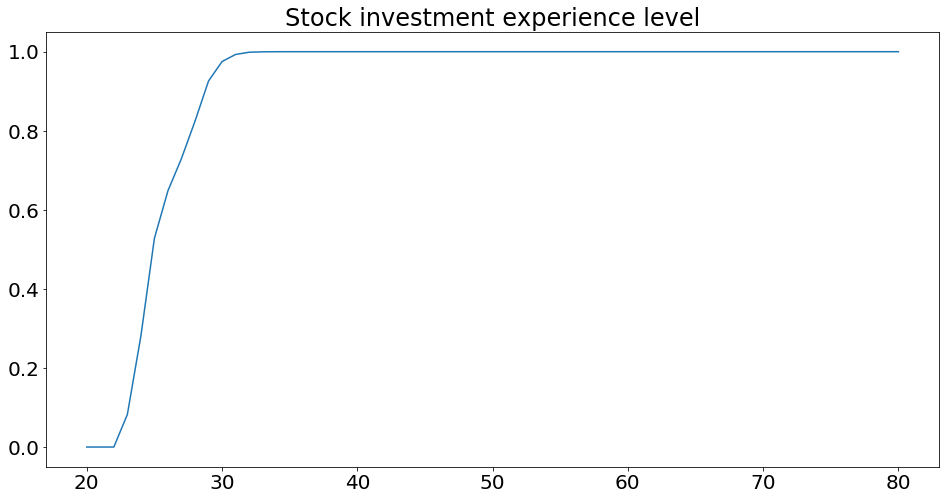

In [48]:
plt.title("Stock investment experience level")
plt.plot(range(20, T_max + 21),jnp.mean(zs,axis = 1), label = "experience")

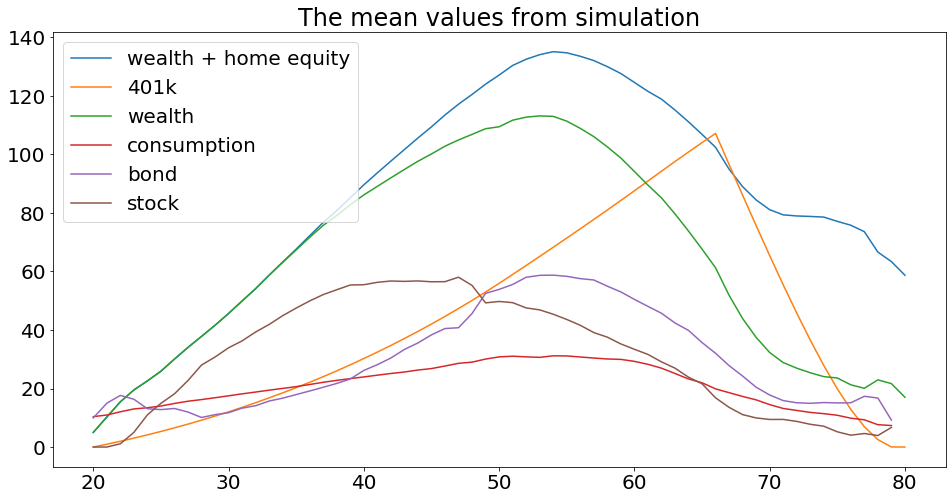

In [51]:
plt.title("The mean values from simulation")
plt.plot(range(20, T_max + 21),jnp.mean(ws + H*pt*os - ms,axis = 1), label = "wealth + home equity")
plt.plot(range(20, T_max + 21),jnp.mean(ns,axis = 1), label = "401k")
plt.plot(range(20, T_max + 21),jnp.mean(ws,axis = 1), label = "wealth")
plt.plot(range(20, T_max + 20),jnp.mean(cs,axis = 1), label = "consumption")
plt.plot(range(20, T_max + 20),jnp.mean(bs,axis = 1), label = "bond")
plt.plot(range(20, T_max + 20),jnp.mean(ks,axis = 1), label = "stock")
plt.legend()

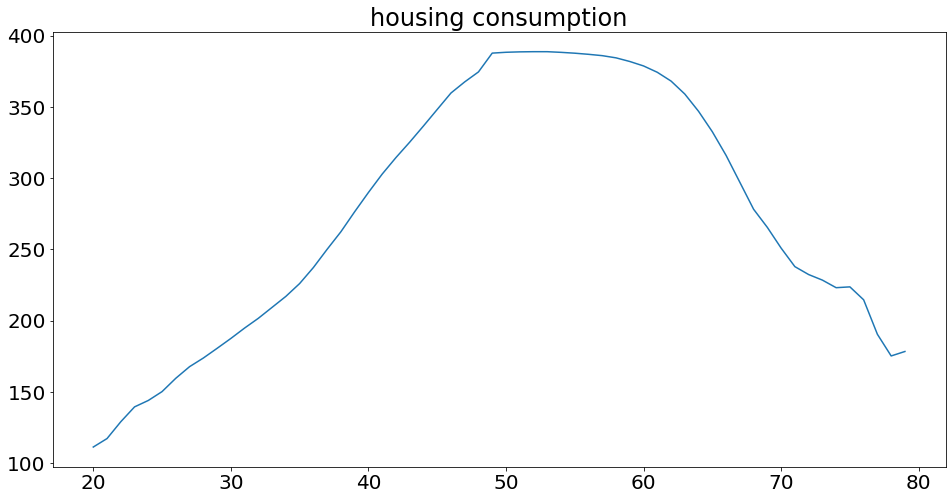

In [52]:
plt.title("housing consumption")
plt.plot(range(20, T_max + 20),(hs).mean(axis = 1), label = "housing")

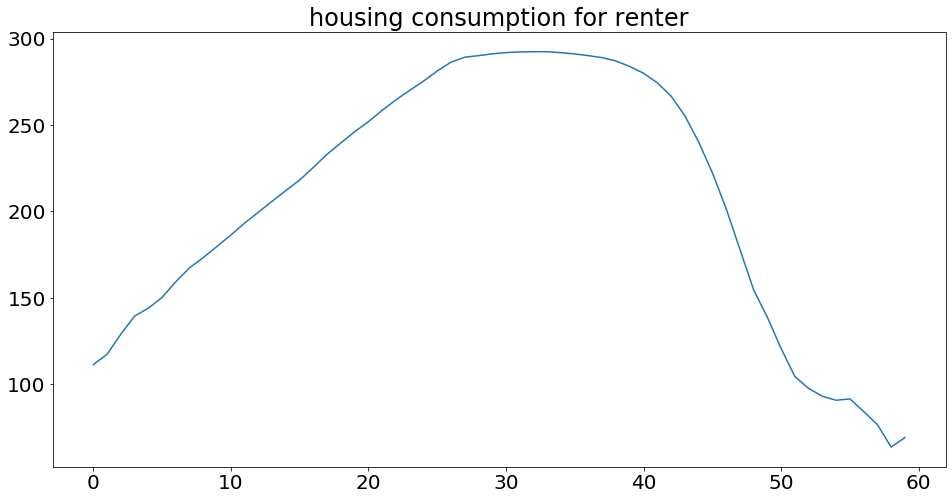

In [53]:
plt.title("housing consumption for renter")
plt.plot(hs[:, jnp.where(os.sum(axis = 0)  == 0)[0]].mean(axis = 1), label = "housing")

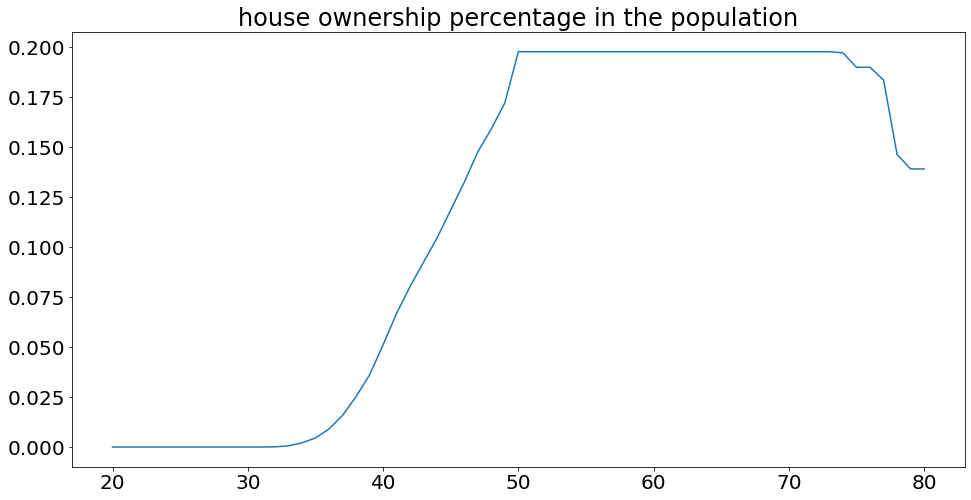

In [54]:
plt.title("house ownership percentage in the population")
plt.plot(range(20, T_max + 21),(os).mean(axis = 1), label = "owning")

In [55]:
# # agent number, x = [w,n,m,s,e,o]
# agentNum = 35
# plt.plot(range(20, T_max + 21),(ws + os*(H*pt - ms))[:,agentNum], label = "wealth + home equity")
# plt.plot(range(20, T_max + 21),ws[:,agentNum], label = "wealth")
# plt.plot(range(20, T_max + 21),ns[:,agentNum], label = "401k")
# plt.plot(range(20, T_max + 21),ms[:,agentNum], label = "mortgage")
# plt.plot(range(20, T_max + 20),cs[:,agentNum], label = "consumption")
# plt.plot(range(20, T_max + 20),bs[:,agentNum], label = "bond")
# plt.plot(range(20, T_max + 20),ks[:,agentNum], label = "stock")
# plt.plot(range(20, T_max + 21),os[:,agentNum]*100, label = "ownership", color = "k")
# plt.legend()

In [56]:
# import pandas as pd
# investmentRatio = np.zeros((nS, T_max))
# for age in range(0,T_max):
#     stockRatio = ks[age,:] / (ks[age,:] + bs[age,:])
#     state = ss[age,:]
#     list_of_tuples = list(zip(stockRatio, state)) 
#     df = pd.DataFrame(list_of_tuples,columns = ['stockRatio', "econState"]) 
#     investmentRatio[:,age] = df.groupby("econState").mean().values.flatten()
# plt.figure()
# for age in range(1,T_max-1, 10):
#     plt.plot(investmentRatio[:,age],label = str(age + 20))
# plt.legend()

In [57]:
# age = 50
# stockRatio = ks[age,:] / (ks[age,:] + bs[age,:])
# state = ss[age,:]
# own = os[age,:]
# list_of_tuples = list(zip(stockRatio, state, own)) 
# df = pd.DataFrame(list_of_tuples,columns = ['stockRatio', "econState", "own"]) 
# owner = df[df["own"] == 1]
# renter = df[df["own"] == 0]
# plt.plot(owner.groupby("econState")["stockRatio"].mean().values.flatten(), label = "Owner")
# plt.plot(renter.groupby("econState")["stockRatio"].mean().values.flatten(), label = "Renter")
# plt.legend()

In [60]:
# agent selling time collection
agentTime = []
for t in range(30):
    if ((os[t,:] == 0) & (os[t+1,:] == 1)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 1))[0]:
            agentTime.append([t, agentNum])
agentTime = jnp.array(agentTime)
# agent selling time collection
agentHold = []
for t in range(30):
    if ((os[t,:] == 0) & (os[t+1,:] == 0)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 0))[0]:
            agentHold.append([t, agentNum])
agentHold = jnp.array(agentHold)

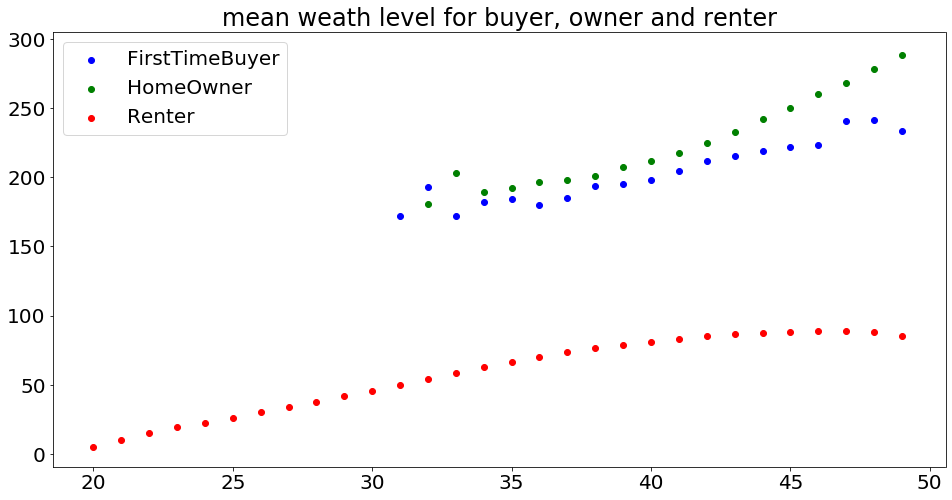

In [61]:
plt.title("mean weath level for buyer, owner and renter")
www = (os*(ws+H*pt - ms)).sum(axis = 1)/(os).sum(axis = 1)
for age in range(30):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    bp = plt.scatter(age+20, ws[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    hp = plt.scatter(age+20, www[age], color = "green")
    rp = plt.scatter(age+20, ws[renter[:,0], renter[:,1]].mean(),color =  "r")
plt.legend((bp,hp,rp), ("FirstTimeBuyer", "HomeOwner", "Renter"))

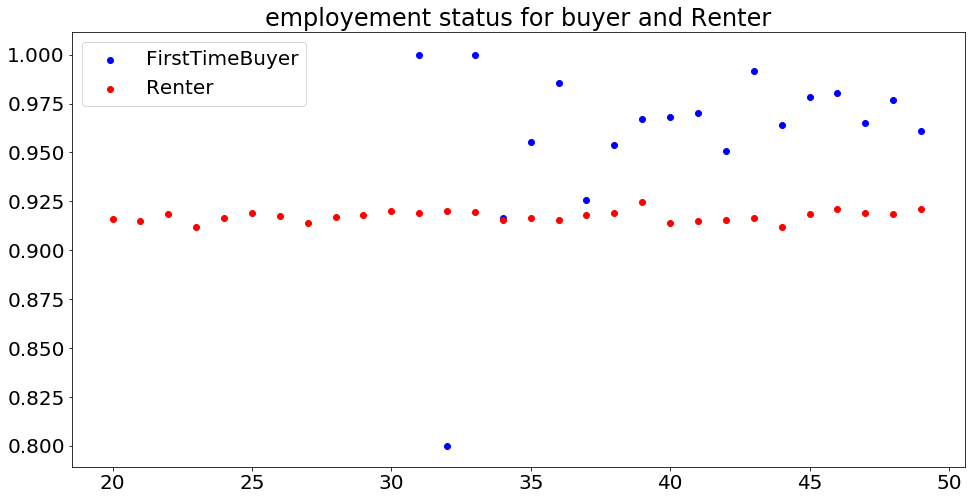

In [62]:
plt.title("employement status for buyer and Renter")
for age in range(31):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    bp = plt.scatter(age+20, es[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    rp = plt.scatter(age+20, es[renter[:,0], renter[:,1]].mean(),color =  "r")
plt.legend((bp, rp), ("FirstTimeBuyer", "Renter"))

In [32]:
# agent selling time collection
agentTime = []
for t in range(T_max):
    if ((zs[t,:] == 0) & (zs[t+1,:] == 1)).sum()>0:
        for agentNum in jnp.where((zs[t,:] == 0) & (zs[t+1,:] == 1))[0]:
            agentTime.append([t, agentNum])
agentTime = jnp.array(agentTime)
# agent selling time collection
agentHold = []
for t in range(T_max):
    if ((zs[t,:] == 0) & (zs[t+1,:] == 0)).sum()>0:
        for agentNum in jnp.where((zs[t,:] == 0) & (zs[t+1,:] == 0))[0]:
            agentHold.append([t, agentNum])
agentHold = jnp.array(agentHold)

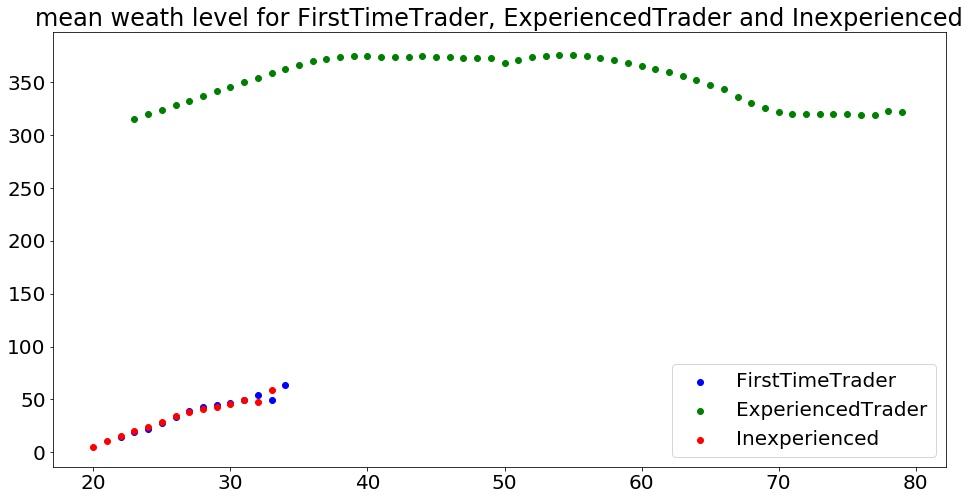

In [33]:
plt.title("mean weath level for FirstTimeTrader, ExperiencedTrader and Inexperienced")
www = (zs*(ws+H*pt - ms)).sum(axis = 1)/(zs).sum(axis = 1)
for age in range(T_max):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    bp = plt.scatter(age+20, ws[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    hp = plt.scatter(age+20, www[age], color = "green")
    rp = plt.scatter(age+20, ws[renter[:,0], renter[:,1]].mean(),color =  "r")
plt.legend((bp,hp,rp), ("FirstTimeTrader", "ExperiencedTrader", "Inexperienced"))

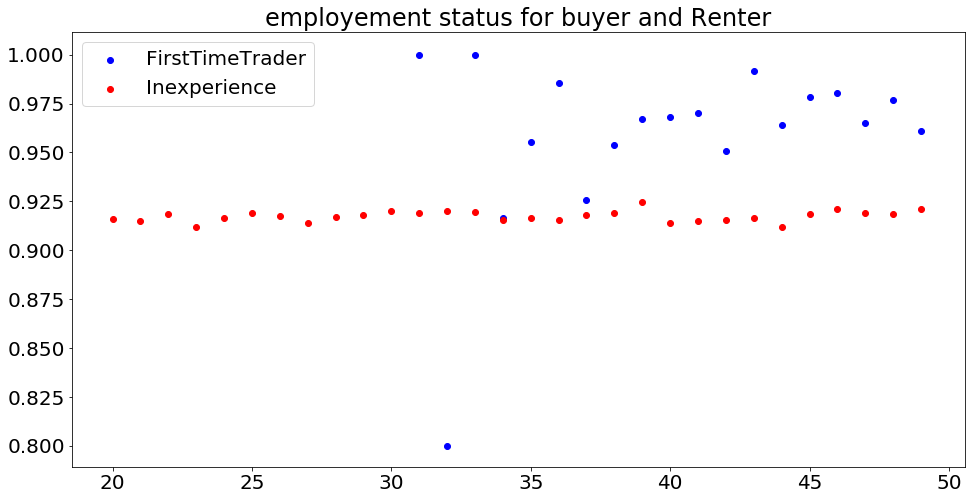

In [58]:
plt.title("employement status for FirstTimeTrader and Inexperienced")
for age in range(T_max):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    bp = plt.scatter(age+20, es[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    rp = plt.scatter(age+20, es[renter[:,0], renter[:,1]].mean(),color =  "r")
plt.legend((bp, rp), ("FirstTimeTrader", "Inexperience"))